In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import os
from distutils.version import LooseVersion as Version
from itertools import product
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix

In [2]:
import torchvision.models as models
net = models.inception_v3()

/home/user/anaconda3/lib/python3.8/site-packages/torchvision/models/inception.py:80: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


In [3]:
net.Conv2d_1a_3x3.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

In [4]:
net.fc = nn.Linear(in_features=2048, out_features=3, bias=True)

In [5]:
net.aux_logits=False

In [6]:
net

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [7]:
if torch.cuda.is_available():
    net = net.cuda()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [10]:
def UploadData(path, train):
    #set up transforms for train and test datasets
    train_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize(512), transforms.CenterCrop(511), transforms.RandomRotation(30),transforms.RandomHorizontalFlip(), transforms.transforms.ToTensor()]) 
    valid_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize(512), transforms.CenterCrop(511), transforms.transforms.ToTensor()]) 
    #test_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize(512), transforms.CenterCrop(511), transforms.ToTensor()])
    
    #set up datasets from Image Folders
    train_dataset = datasets.ImageFolder(path + '/train', transform=train_transforms)
    valid_dataset = datasets.ImageFolder(path + '/validation', transform=valid_transforms)
    #test_dataset = datasets.ImageFolder(path + '/test', transform=test_transforms)

    #set up dataloaders with batch size of 32
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=3, shuffle=True)
    #testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
  
    return trainloader, validloader #, testloader

In [11]:
trainloader, validloader = UploadData("/home/user/research/CXR_Covid-19_Challenge", True) #, testloader

In [12]:
trainloader.dataset.class_to_idx

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [13]:
class_dict = {0: 'covid',
              1: 'normal',
              2: 'pneumonia',
              }


In [14]:
import time
from tqdm import tqdm
from playsound import playsound
def convert(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [15]:
#net.load_state_dict(torch.load("/home/user/research/resnet18/resent_model_100_e.pth"))

In [16]:
f1 = open("loss_train.txt","r")
f2 = open("loss_valid.txt","r")
f3 = open("acc_train.txt","r")
f4 = open("acc_valid.txt","r")
loss_train_list = list(map(float,f1.read().split(",")[:-1]))
loss_valid_list = list(map(float,f2.read().split(",")[:-1]))
acc_train_list = list(map(float,f3.read().split(",")[:-1]))
acc_valid_list = list(map(float,f4.read().split(",")[:-1]))
f1.close()
f2.close()
f3.close()
f4.close()

In [17]:
print(len(loss_train_list))
print(len(loss_valid_list))
print(len(acc_train_list))
print(len(acc_valid_list))

50
50
50
50


In [18]:
min_valid_loss = 176.70111268254743 #np.inf 

In [19]:
net.load_state_dict(torch.load("/home/user/research/inception/inception_model_weights.pth"))

<All keys matched successfully>

  0%|          | 0/1796 [00:00<?, ?it/s]/home/user/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 51 	Training Loss: 0.09165445734263657 	Validation Loss: 0.17152209940613636 	 time: 00:28:32
Train Accuracy : 96.53636169433594 	Validation Accuracy : 94.23077392578125


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 52 	Training Loss: 0.09221583802063996 	Validation Loss: 0.16037222628516629 	 time: 00:23:00
Train Accuracy : 96.73126220703125 	Validation Accuracy : 94.37645721435547


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 53 	Training Loss: 0.08847045124473309 	Validation Loss: 0.2036763697891736 	 time: 00:23:58
Train Accuracy : 96.88160705566406 	Validation Accuracy : 93.79370880126953


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 54 	Training Loss: 0.08789863544174668 	Validation Loss: 0.1687593689412151 	 time: 00:24:31
Train Accuracy : 96.7646713256836 	Validation Accuracy : 94.43473052978516


100%|██████████| 1144/1144 [01:43<00:00, 11.02it/s]


Epoch 55 	Training Loss: 0.09500338172477096 	Validation Loss: 0.14177400080895142 	 time: 00:24:41
Train Accuracy : 96.63102722167969 	Validation Accuracy : 95.10489654541016
Validation Loss Decreased( 176.70111268254743 ---> 162.18945692544042 ) 	 Saving The Model


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 56 	Training Loss: 0.09031265778825509 	Validation Loss: 0.18278716804204703 	 time: 00:24:49
Train Accuracy : 96.74796295166016 	Validation Accuracy : 93.96853637695312


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 57 	Training Loss: 0.08620208682385942 	Validation Loss: 0.14799000272867793 	 time: 00:24:48
Train Accuracy : 96.88160705566406 	Validation Accuracy : 94.90093231201172


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 58 	Training Loss: 0.08300438247726585 	Validation Loss: 0.1600002346522127 	 time: 00:24:55
Train Accuracy : 97.0263900756836 	Validation Accuracy : 94.43473052978516


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 59 	Training Loss: 0.08226122751776815 	Validation Loss: 0.14605365284565963 	 time: 00:24:55
Train Accuracy : 97.13219451904297 	Validation Accuracy : 95.10489654541016


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 60 	Training Loss: 0.08579505991390575 	Validation Loss: 0.18423723773755435 	 time: 00:24:52
Train Accuracy : 96.97627258300781 	Validation Accuracy : 93.47319793701172


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 61 	Training Loss: 0.08214815120575526 	Validation Loss: 0.17847097962048566 	 time: 00:26:59
Train Accuracy : 97.06536865234375 	Validation Accuracy : 94.23077392578125


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 62 	Training Loss: 0.07662939100897298 	Validation Loss: 0.16315428260541065 	 time: 00:25:29
Train Accuracy : 97.11548614501953 	Validation Accuracy : 94.60955810546875


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 63 	Training Loss: 0.07747971859184274 	Validation Loss: 0.22504110104722083 	 time: 00:23:24
Train Accuracy : 97.34379577636719 	Validation Accuracy : 93.18182373046875


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 64 	Training Loss: 0.07793970416078122 	Validation Loss: 0.1685476378482461 	 time: 00:23:36
Train Accuracy : 97.13776397705078 	Validation Accuracy : 94.28904724121094


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 65 	Training Loss: 0.07176851012418552 	Validation Loss: 0.1624539961414715 	 time: 00:24:00
Train Accuracy : 97.43846130371094 	Validation Accuracy : 95.22145080566406


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 66 	Training Loss: 0.07633045756118612 	Validation Loss: 0.16267618834170236 	 time: 00:23:25
Train Accuracy : 97.26026916503906 	Validation Accuracy : 94.46387481689453


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 67 	Training Loss: 0.07321558582663341 	Validation Loss: 0.21929416910379954 	 time: 00:24:09
Train Accuracy : 97.42733001708984 	Validation Accuracy : 93.50233459472656


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 68 	Training Loss: 0.07049886439466706 	Validation Loss: 0.20767059386729905 	 time: 00:23:23
Train Accuracy : 97.44403076171875 	Validation Accuracy : 93.706298828125


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 69 	Training Loss: 0.06958261082941226 	Validation Loss: 0.20314688874566306 	 time: 00:23:48
Train Accuracy : 97.51085662841797 	Validation Accuracy : 94.55128479003906


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 70 	Training Loss: 0.06615839365227791 	Validation Loss: 0.21894106984455217 	 time: 00:23:49
Train Accuracy : 97.6556396484375 	Validation Accuracy : 94.34732055664062


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 71 	Training Loss: 0.07073798872735443 	Validation Loss: 0.1854989590078617 	 time: 00:23:55
Train Accuracy : 97.42176055908203 	Validation Accuracy : 94.31818389892578


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 72 	Training Loss: 0.06759932948314919 	Validation Loss: 0.16438417145409634 	 time: 00:23:44
Train Accuracy : 97.65007019042969 	Validation Accuracy : 94.72611236572266


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 73 	Training Loss: 0.06808185780105781 	Validation Loss: 0.20492887748025262 	 time: 00:24:27
Train Accuracy : 97.60552215576172 	Validation Accuracy : 93.24009704589844


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 74 	Training Loss: 0.0662040773194995 	Validation Loss: 0.15864856163937738 	 time: 00:24:27
Train Accuracy : 97.61109161376953 	Validation Accuracy : 94.78438568115234


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 75 	Training Loss: 0.06631172326392323 	Validation Loss: 0.17424752525398982 	 time: 00:25:52
Train Accuracy : 97.50528717041016 	Validation Accuracy : 94.69696807861328


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 76 	Training Loss: 0.060300969062300605 	Validation Loss: 0.1800764260328554 	 time: 00:27:55
Train Accuracy : 97.7837142944336 	Validation Accuracy : 94.84265899658203


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 77 	Training Loss: 0.0631895532683778 	Validation Loss: 0.17779819888212697 	 time: 00:28:20
Train Accuracy : 97.74473571777344 	Validation Accuracy : 94.81352233886719


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 78 	Training Loss: 0.06198645626303477 	Validation Loss: 0.22541044369261604 	 time: 00:28:41
Train Accuracy : 97.80599212646484 	Validation Accuracy : 92.89044189453125


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 79 	Training Loss: 0.06146746539060868 	Validation Loss: 0.16276436379049866 	 time: 00:28:44
Train Accuracy : 97.80042266845703 	Validation Accuracy : 94.81352233886719


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 80 	Training Loss: 0.061250413641016646 	Validation Loss: 0.185863304678096 	 time: 00:28:40
Train Accuracy : 97.7892837524414 	Validation Accuracy : 94.66783142089844


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 81 	Training Loss: 0.055994985836952726 	Validation Loss: 0.19503489832381585 	 time: 00:28:28
Train Accuracy : 97.96190643310547 	Validation Accuracy : 94.55128479003906


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 82 	Training Loss: 0.05786731395727391 	Validation Loss: 0.1772332505598556 	 time: 00:26:20
Train Accuracy : 97.93963623046875 	Validation Accuracy : 94.6386947631836


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 83 	Training Loss: 0.05508038126183864 	Validation Loss: 0.17212355645936103 	 time: 00:26:16
Train Accuracy : 98.01202392578125 	Validation Accuracy : 94.81352233886719


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 84 	Training Loss: 0.05333144986953854 	Validation Loss: 0.18769453135639058 	 time: 00:26:19
Train Accuracy : 98.1623764038086 	Validation Accuracy : 94.55128479003906


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 85 	Training Loss: 0.05195518812915562 	Validation Loss: 0.2188312843085706 	 time: 00:26:18
Train Accuracy : 98.1623764038086 	Validation Accuracy : 94.28904724121094


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 86 	Training Loss: 0.05557021407121344 	Validation Loss: 0.16567276273672485 	 time: 00:26:18
Train Accuracy : 97.90621948242188 	Validation Accuracy : 95.22145080566406


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 87 	Training Loss: 0.04761978305685298 	Validation Loss: 0.17063623352618648 	 time: 00:26:16
Train Accuracy : 98.28488159179688 	Validation Accuracy : 94.93006896972656


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 88 	Training Loss: 0.04825140143763275 	Validation Loss: 0.20191060677620382 	 time: 00:26:21
Train Accuracy : 98.29045104980469 	Validation Accuracy : 94.98834991455078


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 89 	Training Loss: 0.05780107012915506 	Validation Loss: 0.174123426197158 	 time: 00:26:26
Train Accuracy : 97.94520568847656 	Validation Accuracy : 94.5804214477539


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 90 	Training Loss: 0.0488213468202301 	Validation Loss: 0.1821983714126591 	 time: 00:26:43
Train Accuracy : 98.28488159179688 	Validation Accuracy : 95.01748657226562


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 91 	Training Loss: 0.04786794898898365 	Validation Loss: 0.21106482365035026 	 time: 00:26:24
Train Accuracy : 98.26818084716797 	Validation Accuracy : 94.37645721435547


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 92 	Training Loss: 0.04460614188660565 	Validation Loss: 0.18981046517962916 	 time: 00:26:29
Train Accuracy : 98.46864318847656 	Validation Accuracy : 95.16316986083984


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 93 	Training Loss: 0.04528368343457531 	Validation Loss: 0.19061526675608978 	 time: 00:26:30
Train Accuracy : 98.37954711914062 	Validation Accuracy : 95.134033203125


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 94 	Training Loss: 0.04315999560623736 	Validation Loss: 0.18479735974127254 	 time: 00:26:34
Train Accuracy : 98.39625549316406 	Validation Accuracy : 94.93006896972656


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 95 	Training Loss: 0.045449965668429 	Validation Loss: 0.21741512184906572 	 time: 00:26:37
Train Accuracy : 98.31272888183594 	Validation Accuracy : 94.6386947631836


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 96 	Training Loss: 0.04930824305741191 	Validation Loss: 0.22110039089647493 	 time: 00:26:37
Train Accuracy : 98.2960205078125 	Validation Accuracy : 93.76457214355469


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 97 	Training Loss: 0.04283826560632438 	Validation Loss: 0.20986085644259478 	 time: 00:26:35
Train Accuracy : 98.40739440917969 	Validation Accuracy : 94.49301147460938


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 98 	Training Loss: 0.04108247859154013 	Validation Loss: 0.2100832273115594 	 time: 00:26:29
Train Accuracy : 98.53546905517578 	Validation Accuracy : 95.04662322998047


  0%|          | 0/1796 [00:00<?, ?it/s]

Epoch 99 	Training Loss: 0.04423610125145301 	Validation Loss: 0.20389257205650918 	 time: 00:26:39
Train Accuracy : 98.32386016845703 	Validation Accuracy : 94.52214813232422


100%|██████████| 1144/1144 [01:54<00:00,  9.97it/s]


Epoch 100 	Training Loss: 0.04032945076981576 	Validation Loss: 0.19798582192817635 	 time: 00:26:48
Train Accuracy : 98.53546905517578 	Validation Accuracy : 94.60955810546875
total time :  21:27:42


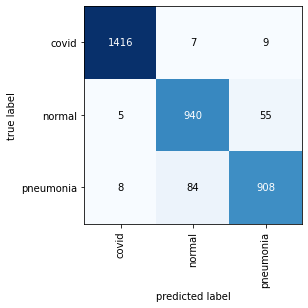

In [20]:
# loss_train_list = []
# loss_valid_list = []
# acc_train_list = []
# acc_valid_list = []

epochs = 50
total_time = time.time()
for e in range(epochs):
    start_time=time.time()
    train_loss = 0.0
    right_train = 0
    total_train = 0
    for data, labels in tqdm(trainloader):
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        net.train()
        # Forward Pass
        target = net(data)
        _, predicted = torch.max(target, 1)
        # Find the Loss
        loss = criterion(target,labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
        correct = (predicted == labels).float().sum()
        right_train+=correct.float()
        total_train+=len(predicted)
     
    valid_loss = 0.0
    right_valid = 0
    total_valid = 0
    net.eval()     # Optional when not using Model Specific layer
    all_targets, all_predictions = [], []
    for data, labels in tqdm(validloader):
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Forward Pass
        target = net(data)
        _, predicted = torch.max(target, 1)
        # Find the Loss
        loss = criterion(target,labels)
        # Calculate Loss
        valid_loss += loss.item()
        correct = (predicted == labels).float().sum()
        right_valid+=correct.float()
        total_valid+=len(predicted)
        all_targets.extend(labels.to('cpu'))
        all_predictions.extend(predicted.to('cpu'))
    ftloss = train_loss / len(trainloader)
    fvloss = valid_loss / len(validloader)
    ftacc = float(right_train*100/total_train)
    fvacc = float(right_valid*100/total_valid)
    loss_train_list.append(ftloss)
    loss_valid_list.append(fvloss)
    acc_train_list.append(ftacc)
    acc_valid_list.append(fvacc)
    print('Epoch',e+51, '\tTraining Loss:',ftloss,'\tValidation Loss:',fvloss,"\t time:",convert(time.time()-start_time))
    print("Train Accuracy :",ftacc,"\tValidation Accuracy :",fvacc)
    if min_valid_loss > valid_loss:
        print("Validation Loss Decreased(",min_valid_loss,"--->",valid_loss,") \t Saving The Model")
        min_valid_loss = valid_loss
        all_predictions = np.array(all_predictions)
        all_targets = np.array(all_targets)
        class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
        if class_labels.shape[0] == 1:
            if class_labels[0] != 0:
                class_labels = np.array([0, class_labels[0]])
            else:
                class_labels = np.array([class_labels[0], 1])
        n_labels = class_labels.shape[0]
        lst = []
        z = list(zip(all_targets, all_predictions))
        for combi in product(class_labels, repeat=2):
            lst.append(z.count(combi))
        mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
        plot_confusion_matrix(mat, class_names=class_dict.values())
        plt.savefig("ConfusionMatrix.png")
        # Saving State Dict
        torch.save(net.state_dict(), '/home/user/research/inception/inception_model_weights.pth')
        torch.save(net,"/home/user/research/inception/inception_model.pt")
print("total time : ",convert(time.time()-total_time))
playsound('/home/user/research/audio')

In [24]:
torch.save(net.state_dict(), '/home/user/research/inception/inception_model_100e_weights.pth')
torch.save(net,"/home/user/research/inception/inception_model_100e.pt")

In [ ]:
# loss_train_list = []
# loss_valid_list = []
# acc_train_list = []
# acc_valid_list = []
# f = open("stats.txt","r")
# for i in f.readlines():
#     if "Loss" in i and "Epoch" in i:
#         e,t,v,time = i.split("\t")
#         train_acc = t.split(" ")[-2]
#         valid_acc = v.split(" ")[-2]
#         loss_train_list.append(float(train_acc))
#         loss_valid_list.append(float(valid_acc))
#     if "Accuracy" in i:
#         t,v = i.split("\t")
#         train_acc = t.split(" ")[-2]
#         valid_acc = v.split(" ")[-1]
#         acc_train_list.append(float(train_acc))
#         acc_valid_list.append(float(valid_acc))

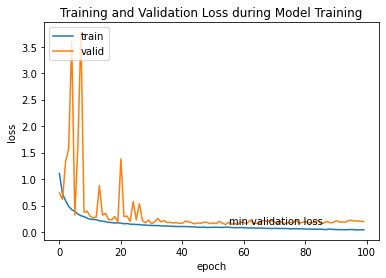

In [21]:
y_v = min(loss_valid_list)
x_v = loss_valid_list.index(y_v)+1
plt.plot(loss_train_list)
plt.plot(loss_valid_list)
plt.annotate("min validation loss",(x_v,y_v))
plt.title('Training and Validation Loss during Model Training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid','minimum'], loc='upper left')
plt.show()

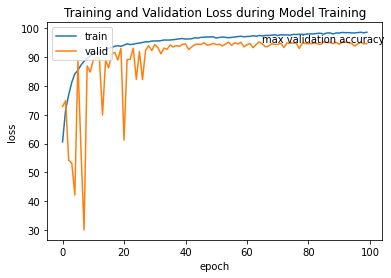

In [22]:
y_a = max(acc_valid_list)
x_a = acc_valid_list.index(y_a)+1
plt.plot(acc_train_list)
plt.plot(acc_valid_list)
plt.annotate("max validation accuracy",(x_a,y_a))
plt.title('Training and Validation Loss during Model Training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [23]:
f1 = open("loss_train.txt","w")
f2 = open("loss_valid.txt","w")
f3 = open("acc_train.txt","w")
f4 = open("acc_valid.txt","w")
for i in range(len(loss_train_list)):
    f1.write(str(loss_train_list[i]))
    f1.write(",")
    f2.write(str(loss_valid_list[i]))
    f2.write(",")
    f3.write(str(acc_train_list[i]))
    f3.write(",")
    f4.write(str(acc_valid_list[i]))
    f4.write(",")
f1.close()
f2.close()
f3.close()
f4.close()

In [ ]:
net.load_state_dict(torch.load("/home/user/research/inception/inception_model_weights.pth"))

In [25]:
right = 0
total = 0
net.eval()
for data, labels in tqdm(validloader):
    if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
    outputs = net(data)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).float().sum()
    right+=correct.float()
    total = total+len(predicted)0 \ol
print(float(right*100/total))

100%|██████████| 1144/1144 [01:06<00:00, 17.25it/s]

94.60955810546875
